In [1]:
import torch
import torch.hub
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
from torchvision import transforms
import cv2
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing
from tqdm import tqdm
import rosbag

import os

from FRM import AutoEncoder, TransformerAutoencoder, legacyAutoEncoder
from feature_dataset import CustomFeatureSensorDataset
from Swin3d import Swin3D_fine_tune, Swin3D

/opt/ros/noetic/lib/python3/dist-packages/rosbag/bag.py:1568: SyntaxWarning: invalid escape sequence '\d'
  matches = re.match("#ROS(.*) V(\d).(\d)", version_line)


In [2]:
model = Swin3D_fine_tune(n_classes=7)

model = torch.load('checkpoints/Swin3d_classifier_all_weights/checkpoint_49.pt',weights_only=False)

model.classifier = nn.Identity()

In [3]:
frm_model = AutoEncoder(input_size=840,
                        num_encoder_layers=3,
                        num_decoder_layers=2,
                        bottleneck_dim=16,
                        dropout_prob=0.1).cuda()
optimizer = optim.AdamW(frm_model.parameters(), lr= 1e-4, weight_decay=0.1)
criterion = nn.L1Loss()

In [4]:
dataset = CustomFeatureSensorDataset('annotated_toledo_dataset_with_bag.pkl')
train_size = int(0.85 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=multiprocessing.cpu_count() // 2,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=multiprocessing.cpu_count() // 2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=multiprocessing.cpu_count() // 2,
    pin_memory=True,
    persistent_workers=True
)

In [5]:
num_epochs = 30

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    # -------------- Train --------------------
    frm_model.train()
    train_loss = 0.0
    
    for feature_vector, _, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        
        feature_vector = feature_vector.squeeze(dim=1)

        feature_vector = feature_vector.cuda()
        optimizer.zero_grad()

        output = frm_model(feature_vector)
        loss = criterion(feature_vector,output)

        loss.backward()
        optimizer.step()

        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # ------------------- Val --------------------------------
    frm_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for feature_vector, _, _ in val_loader:
            
            feature_vector = feature_vector.squeeze(dim=1)
            feature_vector = feature_vector.cuda()

            output = frm_model(feature_vector)
            loss = criterion(feature_vector, output)

            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

Epoch 1/30: 100%|██████████| 63/63 [00:00<00:00, 173.17it/s]


Epoch 1/30 - Train Loss: 1.2031 - Val Loss: 1.0646


Epoch 2/30: 100%|██████████| 63/63 [00:00<00:00, 690.29it/s]


Epoch 2/30 - Train Loss: 1.0370 - Val Loss: 0.9686


Epoch 3/30: 100%|██████████| 63/63 [00:00<00:00, 765.08it/s]


Epoch 3/30 - Train Loss: 0.9693 - Val Loss: 0.9072


Epoch 4/30: 100%|██████████| 63/63 [00:00<00:00, 689.02it/s]


Epoch 4/30 - Train Loss: 0.9244 - Val Loss: 0.8642


Epoch 5/30: 100%|██████████| 63/63 [00:00<00:00, 798.76it/s]


Epoch 5/30 - Train Loss: 0.8872 - Val Loss: 0.8323


Epoch 6/30: 100%|██████████| 63/63 [00:00<00:00, 788.14it/s]


Epoch 6/30 - Train Loss: 0.8519 - Val Loss: 0.7992


Epoch 7/30: 100%|██████████| 63/63 [00:00<00:00, 652.75it/s]


Epoch 7/30 - Train Loss: 0.8184 - Val Loss: 0.7627


Epoch 8/30: 100%|██████████| 63/63 [00:00<00:00, 701.34it/s]


Epoch 8/30 - Train Loss: 0.7896 - Val Loss: 0.7340


Epoch 9/30: 100%|██████████| 63/63 [00:00<00:00, 718.54it/s]


Epoch 9/30 - Train Loss: 0.7611 - Val Loss: 0.7024


Epoch 10/30: 100%|██████████| 63/63 [00:00<00:00, 810.02it/s]


Epoch 10/30 - Train Loss: 0.7282 - Val Loss: 0.6737


Epoch 11/30: 100%|██████████| 63/63 [00:00<00:00, 793.69it/s]


Epoch 11/30 - Train Loss: 0.6984 - Val Loss: 0.6446


Epoch 12/30: 100%|██████████| 63/63 [00:00<00:00, 785.89it/s]


Epoch 12/30 - Train Loss: 0.6640 - Val Loss: 0.6146


Epoch 13/30: 100%|██████████| 63/63 [00:00<00:00, 789.12it/s]


Epoch 13/30 - Train Loss: 0.6336 - Val Loss: 0.5842


Epoch 14/30: 100%|██████████| 63/63 [00:00<00:00, 816.44it/s]


Epoch 14/30 - Train Loss: 0.6030 - Val Loss: 0.5474


Epoch 15/30: 100%|██████████| 63/63 [00:00<00:00, 806.21it/s]


Epoch 15/30 - Train Loss: 0.5776 - Val Loss: 0.5280


Epoch 16/30: 100%|██████████| 63/63 [00:00<00:00, 757.29it/s]


Epoch 16/30 - Train Loss: 0.5545 - Val Loss: 0.5047


Epoch 17/30: 100%|██████████| 63/63 [00:00<00:00, 760.80it/s]


Epoch 17/30 - Train Loss: 0.5381 - Val Loss: 0.4875


Epoch 18/30: 100%|██████████| 63/63 [00:00<00:00, 763.81it/s]


Epoch 18/30 - Train Loss: 0.5204 - Val Loss: 0.4609


Epoch 19/30: 100%|██████████| 63/63 [00:00<00:00, 805.54it/s]


Epoch 19/30 - Train Loss: 0.5093 - Val Loss: 0.4589


Epoch 20/30: 100%|██████████| 63/63 [00:00<00:00, 837.13it/s]


Epoch 20/30 - Train Loss: 0.4980 - Val Loss: 0.4397


Epoch 21/30: 100%|██████████| 63/63 [00:00<00:00, 871.73it/s]


Epoch 21/30 - Train Loss: 0.4864 - Val Loss: 0.4337


Epoch 22/30: 100%|██████████| 63/63 [00:00<00:00, 745.06it/s]


Epoch 22/30 - Train Loss: 0.4741 - Val Loss: 0.4218


Epoch 23/30: 100%|██████████| 63/63 [00:00<00:00, 842.98it/s]


Epoch 23/30 - Train Loss: 0.4655 - Val Loss: 0.4130


Epoch 24/30: 100%|██████████| 63/63 [00:00<00:00, 816.67it/s]


Epoch 24/30 - Train Loss: 0.4574 - Val Loss: 0.4093


Epoch 25/30: 100%|██████████| 63/63 [00:00<00:00, 702.60it/s]


Epoch 25/30 - Train Loss: 0.4479 - Val Loss: 0.3994


Epoch 26/30: 100%|██████████| 63/63 [00:00<00:00, 850.68it/s]


Epoch 26/30 - Train Loss: 0.4395 - Val Loss: 0.3854


Epoch 27/30: 100%|██████████| 63/63 [00:00<00:00, 795.26it/s]


Epoch 27/30 - Train Loss: 0.4319 - Val Loss: 0.3750


Epoch 28/30: 100%|██████████| 63/63 [00:00<00:00, 854.39it/s]


Epoch 28/30 - Train Loss: 0.4271 - Val Loss: 0.3658


Epoch 29/30: 100%|██████████| 63/63 [00:00<00:00, 827.56it/s]


Epoch 29/30 - Train Loss: 0.4222 - Val Loss: 0.3669


Epoch 30/30: 100%|██████████| 63/63 [00:00<00:00, 735.43it/s]

Epoch 30/30 - Train Loss: 0.4162 - Val Loss: 0.3568


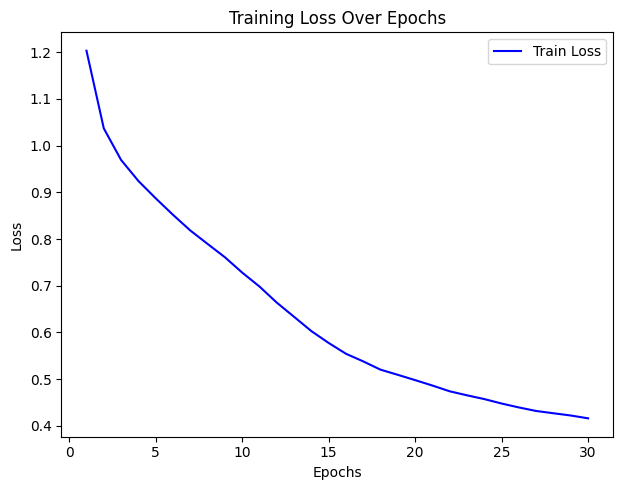

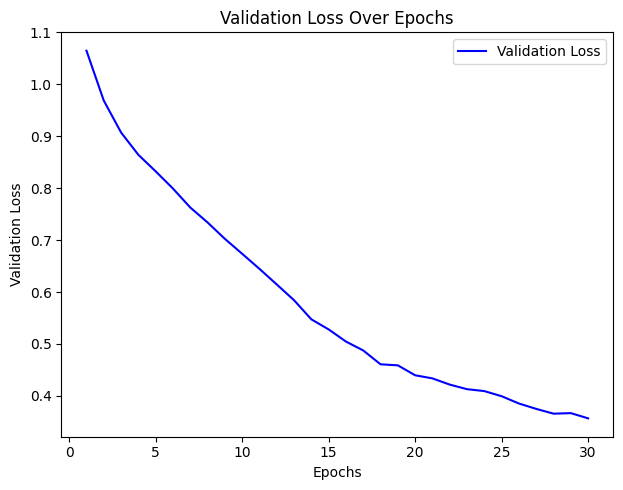

In [6]:
def plot_metrics(train_losses):
    # Convert all elements to CPU floats if they are tensors
    train_losses = [t.cpu().item() if hasattr(t, 'device') else t for t in train_losses]

    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    
    plt.show()
    
    # Plot Val
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, val_losses, label='Validation Loss', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example call after training
plot_metrics(train_losses)

In [7]:
print(f'Last training loss: {train_losses[-1]}')
print(f'Last validation loss: {val_losses[-1]}')
#print(f'Last lr: {scheduler.get_last_lr()}')

Last training loss: 0.41619476344850326
Last validation loss: 0.3568235859274864


In [8]:
test_epochs = 1
test_losses = []

for epoch in range(test_epochs):
    
    frm_model.eval()  # Set model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():  # No gradient computation
        for feature_vector, _, _ in tqdm(test_loader, desc="Testing"):
            feature_vector = feature_vector.squeeze(dim=1)
            feature_vector = feature_vector.cuda()
            
            output = frm_model(feature_vector)
            loss = criterion(feature_vector, output)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Test Loss: {test_loss:.4f}")

Testing: 100%|██████████| 8/8 [00:00<00:00, 71.05it/s]

Test Loss: 0.3875


# Define Threshold:

In [9]:
frm_model.eval()
reconstruction_errors = []

with torch.no_grad():
    for feature_vector, _, _ in tqdm(val_loader, desc="Computing reconstruction errors"):
        
        # Prepare inputs
        feature_vector = feature_vector.squeeze(dim=1).cuda()

        # Forward pass
        output = frm_model(feature_vector)
        
        # Compute L1 reconstruction error per sample using your existing criterion
        # criterion gives a scalar loss if inputs are batched — so compute per sample manually
        errors = torch.mean(torch.abs(feature_vector - output), dim=1)  # L1 per sample

        reconstruction_errors.extend(errors.cpu().numpy())

# Convert to numpy
reconstruction_errors = np.array(reconstruction_errors)

Computing reconstruction errors: 100%|██████████| 4/4 [00:00<00:00, 729.76it/s]


✅ 95th percentile threshold: 0.453112


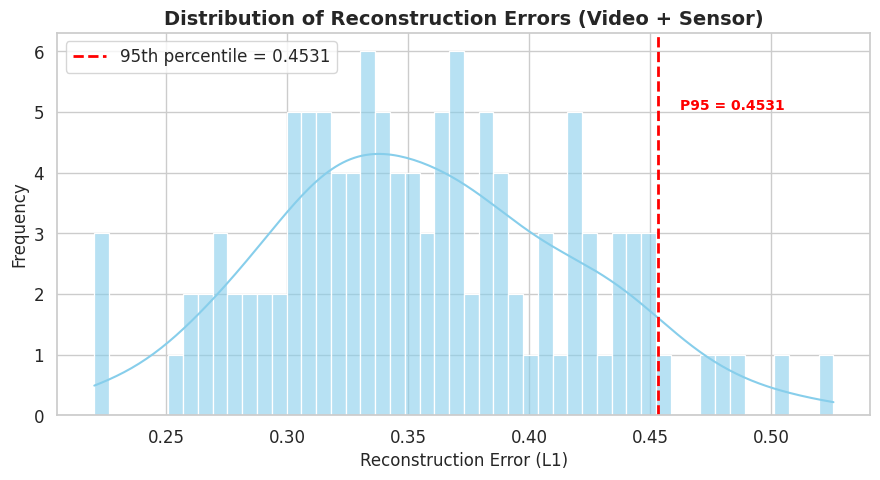

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# --- Compute threshold based on 95th percentile only ---
threshold_95 = np.percentile(reconstruction_errors, 95)

print(f"✅ 95th percentile threshold: {threshold_95:.6f}")

# --- Plot ---
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(9, 5))

sns.histplot(reconstruction_errors, bins=50, kde=True, color='skyblue', alpha=0.6)

# Draw line for the 95th percentile
plt.axvline(threshold_95, color='red', linestyle='--', linewidth=2, label=f'95th percentile = {threshold_95:.4f}')

# Annotate
plt.text(threshold_95 * 1.02, plt.ylim()[1] * 0.8,
         f"P95 = {threshold_95:.4f}",
         color='red', fontsize=10, fontweight='bold')

# Labels and title
plt.xlabel("Reconstruction Error (L1)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Reconstruction Errors (Video + Sensor)", fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()